# Preprocessing AmsterdamUMCdb and MIMIC-III v1.4 Data Files

In this notebook we will preprocess the [AmsterdamUMCdb](https://github.com/AmsterdamUMC) and [MIMIC-III](https://physionet.org/content/mimiciii/1.4/) v1.4 data files as extracted by our data extraction pipeline (see `data/mimic-iii` and `data/amsterdam-umc-db`). Here, we implement a preprocessing pipeline similar to [Roggeveen et al.](https://www.sciencedirect.com/science/article/pii/S0933365720312689), by aggregating measurements into bins of 2-hour2 (as opposed to 4 hours used by Roggeveen et al.).

The [original notebook](https://github.com/LucaMD/SRL/blob/master/SEPSIS/MIMIC_src/MIMIC_R_DataPreprocessing.ipynb) used to preprocess the data files was written in R; I have reimplemented the preprocessing in Python and validated this reimplementation with the original.

In [1]:
## Dependencies
# I/O
import os
import re
import pickle
import pandas as pd
import numpy as np

# Plotting
import random
import matplotlib.pyplot as plt

# Timing
from datetime import timedelta
from tqdm import tqdm

# Imputation
from fancyimpute import KNN

# Suppress scientific notation
np.set_printoptions(suppress=True)

In [2]:
# Settings
INTERVAL_TIME = '2h'
DATA_DIR = 'D:/amsterdam-umc-db/final/'                           # Where mimic-iii/amsterdamumcdb is kept
OUTPUT_DIR = 'datasets/amsterdam-umc-db/aggregated_full_cohort'  # Where preprocessed data will be stored

In [3]:
# Check if mimic-iii folder exists
if not os.path.exists(DATA_DIR):
    raise Exception('Dataset directory %s does not exist!' % DATA_DIR)

# Create OUTPUT_DIR and checkpoints subdirectory
OUTPUT_DIR = OUTPUT_DIR + '_%s' % INTERVAL_TIME
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    os.makedirs(OUTPUT_DIR + '/checkpoints')
    

<br>

**Convenience functions**<br>
For simplicity, we define a number of convenience functions we can reuse throughout the notebook (for loading data, plotting, unit conversions, etc.);

In [4]:
# make explicit as parse_dates=True fails to cast starttime and endtime as timestamps ¯\_(ツ)_/¯
PARSABLE_DATES = ['intime', 'outtime', 'starttime', 'endtime', 'window_start', 
                  'window_end', 'charttime', 'suspected_infection_time_poe']
    
# reads a .csv file and parses datetime columns using pd.to_datetime()
def read_csv(fname, usecols=None):
    df = pd.read_csv(fname, usecols=None)    
    for col in PARSABLE_DATES:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
    return df

In [5]:
# saves dict as pickle file
def save_dict(dir_, name, dct):
    with open(os.path.join(dir_, 'checkpoint_' + name + '.pkl'), 'wb') as file:
        pickle.dump(dct, file)
        

In [6]:
# Plots for a (random) admission the values of one feature
def plot_df(df, feature, icustay_id=None):
    if icustay_id is None:
        icustay_id = random.choice(df.icustay_id.unique())
        
    icustay = df[df.icustay_id == icustay_id]
    
    plt.figure(figsize=(10, 3))
    plt.plot(icustay.timestep, icustay[feature], color='C0', linestyle='-')
    plt.plot(icustay.timestep, icustay[feature], color='C0', marker='.')
    plt.plot()
    return icustay_id


In [7]:
# plots values of under `feature` over time
def plot_dct(dct, feature, title='', xlabel='Timestep', ylabel='Value', style='-'):
    icustay_id = None
    x = None
    y = None
    
    icustay_ids = list(dct.keys())
    while x is None:
        # Pick a random ICU stay from dct
        icustay_id = random.choice(icustay_ids)
        
        # Continue if no data logged for key
        if feature not in dct[icustay_id]:
            continue
        
        # Continue if values are all zeros/NaNs (e.g. to mark no fluids were administered)
        data = np.nan_to_num(dct[icustay_id][feature])
        if np.mean(data) != 0:
            x = dct[icustay_id]['timestep']
            y = dct[icustay_id][feature]
            
    if len(x) > len(y):
        x = x[:len(y)]
                            
    plt.figure(figsize=(8, 3))
    plt.plot(x, y, style, label=str(icustay_id))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
    

In [8]:
# Converts a series of deltatime objects into hours
def to_hours(x):
    return x.astype('timedelta64[s]').astype(int) / 3600


In [9]:
# Converts upper- or camelcase to snake-case (lowercase with '_' separators)
def to_snakecase(string):
    if string.islower():
        return string
    elif string.isupper():
        return string.lower()
    else:
        string = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', string)
        return re.sub('([a-z0-9])([A-Z])', r'\1_\2', string).lower()
    
print('HeartRate => %s' % to_snakecase('HeartRate'))
print('ALBUMIN   => %s' % to_snakecase('ALBUMIN'))
print('MeanBP    => %s' % to_snakecase('MeanBP'))

HeartRate => heart_rate
ALBUMIN   => albumin
MeanBP    => mean_bp


---
## Patient Cohort

Using MIMIC-Code we have extracted a patient cohort (i.e. a list of adult patients older than 17 years of age) along with information regarding the suspected time of infection and in-hospital mortality. Let's first import these data;

In [10]:
cohort_df = read_csv(DATA_DIR + 'cohort.csv')
print('Number of admissions: %s\n' % len(cohort_df))
cohort_df.head()

Number of admissions: 23106



,icustay_id,window_start,window_end,hospital_expire_flag
0,0,2022-11-24 13:19:57.069790,2022-11-27 13:19:57.069790,0
1,1,2022-11-24 13:19:57.069790,2022-11-27 13:19:57.069790,0
2,2,2022-11-24 13:19:57.069790,2022-11-27 13:19:57.069790,0
3,3,2022-11-24 13:19:57.069790,2022-11-27 13:19:57.069790,0
4,4,2022-11-24 13:19:57.069790,2022-11-27 13:19:57.069790,0


<br>

**Collecting the data**<br>
For convenience, we will collect features in a dict, mapping from each admission (`icustay_id`) to the corresponding data of features (`heart_rate`, `sys_bp`, `wbc`) or actions (e.g. `max_vaso`);

In [11]:
# We will store our results in this dict
data = {icustay_id: dict() for icustay_id in cohort_df.icustay_id.unique()}

---

## $x$-Hour Time Intervals

For each admission, we will compute all intermediate timesteps in increments of $\Delta t=2$ hours (defined by `INTERVAL_TIME`). Each time we add our output to `data`;

In [12]:
def date_range(icustay, freq):
    starttime = icustay.window_start  # start of admission
    endtime = icustay.window_end      # 72 hours later
    return pd.date_range(start=starttime, end=endtime, freq=freq).values
    
icustay_timesteps = {icustay['icustay_id']: date_range(icustay, freq=INTERVAL_TIME) for _, icustay in cohort_df.iterrows()}

In [13]:
for icustay_id, timesteps in icustay_timesteps.items():
    data[icustay_id]['timestep'] = timesteps

In [14]:
# Plot timesteps of random admission
icustay_id = random.choice(cohort_df.icustay_id.unique())
data[icustay_id]['timestep'][:5]

array(['2022-11-24T13:19:57.069790000', '2022-11-24T15:19:57.069790000',
       '2022-11-24T17:19:57.069790000', '2022-11-24T19:19:57.069790000',
       '2022-11-24T21:19:57.069790000'], dtype='datetime64[ns]')

In [15]:
# Save!
save_dict(OUTPUT_DIR, 'timestep', {i:data[i]['timestep'] for i in data if 'timestep' in data[i]})

---
## Vasopressors

### 1. MetaVision Records

In [16]:
# Load data file from MIMIC-Code
vaso_df = read_csv(DATA_DIR + 'vasopressors_mv_cohort.csv')
print('Number of admissions:', len(vaso_df.icustay_id.unique()))
vaso_df.head()

Number of admissions: 13243


,icustay_id,starttime,endtime,mcgkgmin
0,1,2022-11-23 15:54:54.935704,2022-11-23 20:55:54.935704,0.080000
1,2,2022-11-23 15:26:54.935704,2022-11-23 16:02:54.935704,0.006667
2,2,2022-11-23 16:02:54.935704,2022-11-23 16:22:54.935704,0.010000
3,2,2022-11-23 16:22:54.935704,2022-11-23 16:37:54.935704,0.006667
4,2,2022-11-23 16:37:54.935704,2022-11-23 16:55:54.935704,0.003333


**Computing maximum vasopressor dose**<br>

For each admission (i.e. ICU stay), we iterate over timesteps $t$ and determine which treatments overlap with its 2-hour history (i.e. which treatments occurred between $x$ hours ago and now). We then record the maximum rate of these treatments.

In [17]:
# Consider ICU stays one-by-one
for icustay_id, treatments in tqdm(vaso_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in data:
        continue
        
    # To store vasopressor doses into
    timesteps = icustay_timesteps[icustay_id]
    max_vaso = np.zeros(len(timesteps) - 1, dtype=np.float32)
    
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: treatment time overlaps with current interval.
        # Remark: original R-code erroneously used 'treatment[endtime] <= interval_end' as first term
        condition = (treatments.starttime <= interval_end) & (treatments.endtime > interval_start)
        
        # Compute max vasopressor intake in mcg/kg/min (norepinephrine-equivalent)
        max_vaso[i] = treatments[condition].mcgkgmin.max()
        max_vaso[i] = np.nan_to_num(max_vaso[i], nan=0.0)
        
    data[icustay_id]['max_vaso'] = max_vaso
    
del vaso_df

100%|████████████████████████████████████████████████████████████████████████████| 13243/13243 [06:19<00:00, 34.93it/s]


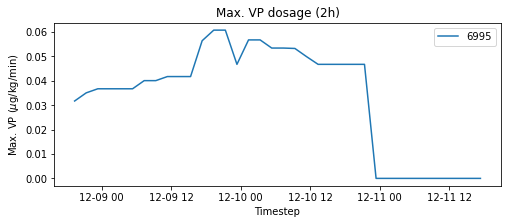

In [69]:
# Plot vasopressors of random admission
plot_dct(
    dct=data, 
    feature='max_vaso', 
    title='Max. VP dosage (%s)' % INTERVAL_TIME, 
    ylabel='Max. VP ($\mu$g/kg/min)', 
    style='-'
)

**Sanity checks**

In [70]:
# Does the action space look like Roggeveen et al.?
max_vasos = np.concatenate([x['max_vaso'] for x in data.values() if 'max_vaso' in x]).flatten()

# Exclude overrepresented zero doses for now
max_vasos = max_vasos[max_vasos > 0]

np.quantile(max_vasos, np.linspace(0, 1, 5)).round(4) # Approved!

array([  0.0002,   0.0067,   0.0133,   0.035 , 333.3333])

Compare with quartiles from (Roggeveen et al., 2021) in mcg/kg/$\underline{hour}$ obtained from MIMIC-III:
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-8jgo{border-color:#ffffff;text-align:center;vertical-align:top}
</style>
<table class="tg" align="left">
<thead>
  <tr>
    <th class="tg-8jgo">0%</th>
    <th class="tg-8jgo">25%</th>
    <th class="tg-8jgo">50%</th>
    <th class="tg-8jgo">75%</th>
    <th class="tg-8jgo">100%</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-8jgo">0.002</td>
    <td class="tg-8jgo">0.11016</td>
    <td class="tg-8jgo">0.22509</td>
    <td class="tg-8jgo">0.45035</td>
    <td class="tg-8jgo">222.73125</td>
  </tr>
</tbody>
</table>

<br><br><br>

Do note, these relate to sepsis patients only and may hence differ ever so slightly from those obtained above.

In [71]:
# Save!
save_dict(OUTPUT_DIR + '/checkpoints', 'max_vaso', {i:data[i]['max_vaso'] for i in data if 'max_vaso' in data[i]})

---
## IV Fluids

### 1. MetaVision Records

Source: Komorowski et al. [[link]](https://github.com/matthieukomorowski/AI_Clinician/blob/master/AIClinician_Data_extract_MIMIC3_140219.ipynb)

In [78]:
TONICITY_FACTORS = {
    30176: 0.25,
    30315: 0.25,
    30161: 0.3,
    30020: 0.5,
    30015: 0.5,
    225823: 0.5,
    30321: 0.5,
    30186: 0.5,
    30211: 0.5, 
    30353: 0.5,
    42742: 0.5,
    42244: 0.5,
    225159: 0.5,
    227531: 2.75,
    30143: 3,
    225161: 3,
    30009: 5,
    220862: 5,
    30030: 6.66,
    220995: 6.66,
    227533: 6.66,
    228341: 8
}

# Itemids of colloid/crystalloid solutions in MIMIC-III; -1 for AmsterdamUMCdb
IV_ITEMIDS = {225158,225943,226089,225168,225828,225823,220862,220970,220864,225159,220995,225170,
              225825,227533,225161,227531,225171,225827,225941,225823,225825,225941,225825,228341,
              225827,30018,30021,30015,30296,30020,30066,30001,30030,30060,30005,30321,30006,30061,
              30009,30179,30190,30143,30160,30008,30168,30186,30211,30353,30159,30007,30185,30063,
              30094,30352,30014,30011,30210,46493,45399,46516,40850,30176,30161,30381,30315,42742,
              30180,46087,41491,30004,42698,42244,220949,225944,227523,-1}

IV_CATEGORIES = [
    # MIMIC-III
    '01-Drips',
    '02-Fluids (Crystalloids)',
    '04-Fluids (Colloids)',
    '03-IV Fluid Bolus',
    '10-Prophylaxis (IV)',
    '07-Blood Products',
    # AmsterdamUMCdb
    'Infuus - Colloid', 
    'Infuus - Crystalloid',
    'Infuus - Bloedproducten', 
    '2. Spuitpompen'
]

**Drop non-IV fluid events**

In [80]:
ivfluid_df = read_csv(DATA_DIR + 'inputevents_mv_cohort.csv')

# Drop 14-Oral/Gastric Intake (i.e. having a glass of water) and other Non-IV input events
# Remark: In (Roggeveen et al., 2021) only '14-Oral/Gastric Intake' was dropped causing
# various Non-IV treatments (such as '13-Enteral Nutrition') to become part of IV fluids
ivfluid_df = ivfluid_df.loc[ivfluid_df.ordercategoryname.isin(IV_CATEGORIES) & ivfluid_df.itemid.isin(IV_ITEMIDS) & (ivfluid_df.amountuom == 'ml')]

# Sanity check: remove amounts outside (0, 5000) range
ivfluid_df = ivfluid_df[(ivfluid_df.amount > 0) & (ivfluid_df.amount < 5000) & ivfluid_df.amount.notna()]

# Compute duration in hours
# Remark: original erroneously measured time in a mix of hours and minutes (due to unit='auto')
ivfluid_df['duration'] = to_hours(ivfluid_df.endtime - ivfluid_df.starttime)

# if duration is 1 minute and per bolus, set duration to 1H
# the 1 minute is an artifact of data gathering and results in unreasonably high doses of NaCL and Lactated Ringer
# see: https://www.bbraun.ph/content/dam/catalog/bbraun/bbraunProductCatalog/S/AEM2015/en-ph/b/12615576-0314-lactatedringerssolution.pdf
# condition = (ivfluid_df.duration <= 0.017) & (ivfluid_df.ordercategorydescription == 'Bolus')
# ivfluid_df.loc[condition, 'duration'] = 1
# ivfluid_df.loc[condition, 'endtime'] = ivfluid_df['starttime'] + pd.Timedelta(hours=1)

# Drop unused columns
ivfluid_df = ivfluid_df[['icustay_id', 'itemid', 'starttime', 'endtime', 'amount', 'duration', 'ordercategoryname']]
ivfluid_df.head()

,icustay_id,itemid,starttime,endtime,amount,duration,ordercategoryname
0,0,-1,2022-11-23 23:33:54.935704,2022-11-24 00:33:54.935704,500.0,1.000000,Infuus - Colloid
1,0,-1,2022-11-24 03:47:54.935704,2022-11-24 04:47:54.935704,500.0,1.000000,Infuus - Colloid
2,0,-1,2022-11-24 15:33:54.935704,2022-11-24 16:03:54.935704,500.0,0.500000,Infuus - Colloid
3,0,-1,2022-11-25 01:40:54.935704,2022-11-25 02:40:54.935704,500.0,1.000000,Infuus - Colloid
4,0,-1,2022-11-23 20:46:54.935704,2022-11-24 04:27:54.935704,500.0,7.683333,Infuus - Crystalloid


**Correct for tonicity**

In [81]:
def correct_for_tonicity(df):
    for item_id, factor in TONICITY_FACTORS.items():
        df.loc[df.itemid == item_id, 'amount'] = factor * df.amount[df.itemid == item_id]
    return df

# Remark: Tonicity correction was not done in (Roggeveen et al., 2021) although standard practice
ivfluid_df = correct_for_tonicity(ivfluid_df)
ivfluid_df.head()

,icustay_id,itemid,starttime,endtime,amount,duration,ordercategoryname
0,0,-1,2022-11-23 23:33:54.935704,2022-11-24 00:33:54.935704,500.0,1.000000,Infuus - Colloid
1,0,-1,2022-11-24 03:47:54.935704,2022-11-24 04:47:54.935704,500.0,1.000000,Infuus - Colloid
2,0,-1,2022-11-24 15:33:54.935704,2022-11-24 16:03:54.935704,500.0,0.500000,Infuus - Colloid
3,0,-1,2022-11-25 01:40:54.935704,2022-11-25 02:40:54.935704,500.0,1.000000,Infuus - Colloid
4,0,-1,2022-11-23 20:46:54.935704,2022-11-24 04:27:54.935704,500.0,7.683333,Infuus - Crystalloid


**Computing total intake of IV fluids**<br>

In order to determine the total amount of IV fluid administered within a 4 hour interval, we need to calculate how long a treatment was administered for during an interval; multiplied by the rate (i.e. `amount / duration`) we can infer the total amount administered by each treatment during the current interval. For this we use the `total_admin_in_interval` function below:

In [82]:
# Computes how much of each dose was administered between interval_start and interval_end
def total_admin_in_interval(interval_start, interval_end, treatments):
    dose_start = treatments.starttime
    dose_end = treatments.endtime
    amount = treatments.amount
    duration = treatments.duration
    rate = amount / duration # in ml/hour!   
    
    total_ml = 0
    
    # Option 1: Dose started before interval and ended after interval
    c1 = (dose_start < interval_start) & (dose_end > interval_end)
    if c1.any():
        total_ml += (to_hours(interval_end - interval_start) * rate[c1]).sum()
    
    # Option 2: Dose started before and ended within interval
    c2 = (dose_start < interval_start) & (dose_end > interval_start) & (dose_end <= interval_end)
    if c2.any():
        total_ml += (to_hours(dose_end - interval_start) * rate[c2]).sum()

    # Option 3: Dose started and ended in interval
    c3 = (dose_start >= interval_start) & (dose_start < interval_end) & (dose_end <= interval_end) & (dose_end > interval_start)
    if c3.any():
        total_ml += amount[c3].sum()
    
    # Option 4: dose started in interval and ended after interval
    # Remark: Extra division by duration in original notebook
    # Remark: In original notebook, > in first term causes treatments to be skipped starting exactly at interval start
    c4 = (dose_start >= interval_start) & (dose_start < interval_end) & (dose_end > interval_end)
    if c4.any():
        total_ml += (to_hours(interval_end - dose_start) * rate[c4]).sum()
            
    return total_ml

We can now use `total_admin_in_interval()` on each interval `(interval_start, interval_end)` and treatment in `ivfluid_mv_df` to compute the total IV fluid administration:

In [83]:
for icustay_id, treatments in tqdm(ivfluid_df.groupby('icustay_id'), desc='Grab some coffee'):
    
    # Is icustay part of cohort?
    if icustay_id not in data:
        continue
    
    # Store fluid intake in vector
    timesteps = icustay_timesteps[icustay_id]
    total_ivfluid = np.zeros(len(timesteps) - 1, dtype=np.float32)
    
    # Compute total IV fluid within each interval
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        total_ivfluid[i] = total_admin_in_interval(interval_start, interval_end, treatments)
        
    # Save!
    data[icustay_id]['total_iv_fluid'] = total_ivfluid
    
del ivfluid_df

Grab some coffee: 100%|██████████████████████████████████████████████████████████| 22883/22883 [36:54<00:00, 10.33it/s]


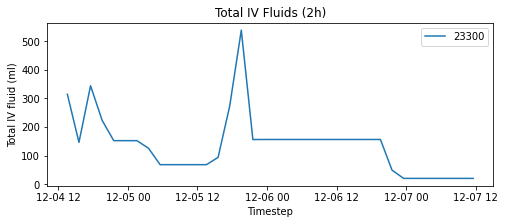

In [170]:
# Show IV fluids from random admission
plot_dct(
    dct=data, 
    feature='total_iv_fluid', 
    title='Total IV Fluids (%s)' % INTERVAL_TIME, 
    ylabel='Total IV fluid (ml)', 
    style='-'
)

**Sanity checks**

In [138]:
# Does the action space look like Roggeveen et al.?
iv_fluids = np.concatenate([x['total_iv_fluid'] for x in data.values() if 'total_iv_fluid' in x]).flatten()
iv_fluids = iv_fluids[iv_fluids >= 0.001]
np.nanquantile(iv_fluids, np.linspace(0, 1, 5)).round(3)

array([   0.047,   30.   ,   97.912,  172.039, 5514.725])

<br>

Quartiles from (Roggeveen et al., 2021) are different, due to additional division by `duration` (see `#remark`), difference in aggregation interval and tonicity correction:
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-8jgo{border-color:#ffffff;text-align:center;vertical-align:top}
</style>
<table class="tg" align="left">
<thead>
  <tr>
    <th class="tg-c3ow">0%</th>
    <th class="tg-c3ow">25%</th>
    <th class="tg-c3ow">50%</th>
    <th class="tg-c3ow">75%</th>
    <th class="tg-c3ow">100%</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-c3ow">0.000</td>
    <td class="tg-c3ow">39.834</td>
    <td class="tg-c3ow">204.403</td>
    <td class="tg-c3ow">635.205</td>
    <td class="tg-c3ow">24852.551</td>
  </tr>
</tbody>
</table>

In [139]:
# Save!
save_dict(OUTPUT_DIR + '/checkpoints', 'total_iv_fluid', {i:data[i]['total_iv_fluid'] for i in data if 'total_iv_fluid' in data[i]})

### IV Fluid Running Total 

In Roggeveen et al. an additional feature is incorporated which measures the total IV fluid administered up to the current timestep. We implement this here using `np.cumsum` over the previously computed IV fluid balances;

In [140]:
for icustay_id, icustay_data in data.items():
    if 'total_iv_fluid' in icustay_data.keys():
        data[icustay_id]['running_total_iv_fluid'] = np.cumsum(np.nan_to_num(icustay_data['total_iv_fluid'], nan=0.0))

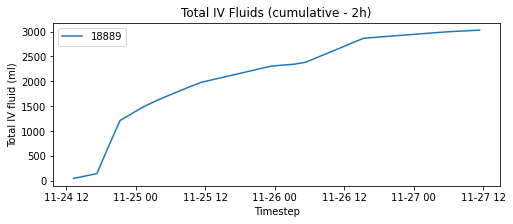

In [173]:
# Grab IV fluids from random patient
plot_dct(
    dct=data, 
    feature='running_total_iv_fluid', 
    title='Total IV Fluids (cumulative - %s)' % INTERVAL_TIME, 
    ylabel='Total IV fluid (ml)', 
    style='-'
)

In [142]:
# Save!
save_dict(OUTPUT_DIR + '/checkpoints', 'running_total_iv_fluid', {i:data[i]['running_total_iv_fluid'] for i in data if 'running_total_iv_fluid' in data[i]})

---
## Vital functions

In [174]:
vitals_df = read_csv(DATA_DIR + 'vitals_cohort.csv')
vitals_df.head()

,icustay_id,charttime,vital_id,valuenum
0,0,2022-11-23 19:15:00,Glucose,11.4
1,0,2022-11-23 19:45:00,DiasBP,49.0
2,0,2022-11-23 19:45:00,HeartRate,83.0
3,0,2022-11-23 19:45:00,MeanBP,68.0
4,0,2022-11-23 19:45:00,RespRate,13.0


In [175]:
# List vitals recorded
ALL_VITALS = list(vitals_df.vital_id.unique())
print(ALL_VITALS)

['Glucose', 'DiasBP', 'HeartRate', 'MeanBP', 'RespRate', 'SpO2', 'SvO2', 'SysBP', 'TempC']


In [176]:
for icustay_id, measurements in tqdm(vitals_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    # Add keys for each vital_id to data with empty measurements vector
    timesteps = icustay_timesteps[icustay_id]
    for vital_id in ALL_VITALS:
        data[icustay_id][to_snakecase(vital_id)] = np.full(len(timesteps) - 1, np.nan)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: charttime in (interval_start, interval_end)
        condition = (measurements.charttime > interval_start) & (measurements.charttime <= interval_end)  
        
        # Compute average value of each vital_id
        vital_means = measurements[condition].groupby('vital_id').valuenum.mean()
        
        for vital_id, value in vital_means.items():
            data[icustay_id][to_snakecase(vital_id)][i] = value
            
del vitals_df

100%|████████████████████████████████████████████████████████████████████████████| 23093/23093 [18:28<00:00, 20.83it/s]


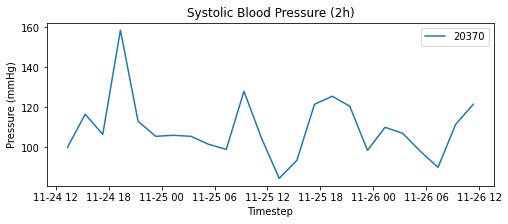

In [244]:
# Show SysBP from random patient
plot_dct(
    dct=data, 
    feature='sys_bp', 
    title='Systolic Blood Pressure (%s)' % INTERVAL_TIME, 
    ylabel='Pressure (mmHg)',
    style='-'
)

In [245]:
# Save!
for vital_id in ALL_VITALS:
    vital_id = to_snakecase(vital_id)
    save_dict(OUTPUT_DIR + '/checkpoints', vital_id, {i:data[i][vital_id] for i in data if vital_id in data[i]})

---
## Lab Results

In [246]:
# load lab results (only necessary columns)
lab_df = read_csv(DATA_DIR + 'labs_cohort.csv', usecols=['icustay_id', 'charttime', 'lab_id', 'valuenum'])

# if exists, add additional file with hemotocrit, D-Dimer and SvO2.
# In AmsterdamUMCdb, it is included in vitals/lab results
# In MIMIC-III it is stored separately, therefore must be appended explicitly
if os.path.exists(DATA_DIR + 'hematocrit_d-dimer_svo2.csv'):
    print('Including hematocrit, D-dimer and SvO2')
    hema_df = read_csv(DATA_DIR + 'hematocrit_d-dimer_svo2.csv')
    lab_df = pd.concat([lab_df, hema_df], axis=0)

# Drop rows with NaNs
lab_df = lab_df[~(lab_df.valuenum.isna() | lab_df.lab_id.isna())]

lab_df.head()

,icustay_id,charttime,lab_id,valuenum
0,0,2022-11-24 19:25:57.069790,CALCIUM,2.28
1,0,2022-11-25 02:00:57.069790,CALCIUM,2.10
2,1,2022-11-24 13:44:57.069790,CALCIUM,2.01
3,1,2022-11-24 16:14:57.069790,CALCIUM,2.08
4,2,2022-11-24 13:40:57.069790,CALCIUM,2.02


In [248]:
# List hormones / fluids measured
ALL_LAB_IDS = list(lab_df['lab_id'].unique())
print(ALL_LAB_IDS) 

['CALCIUM', 'ION_CALCIUM', 'PTT', 'POTASSIUM', 'PLATELET', 'ANION GAP', 'PAO2', 'WBC', 'SODIUM', 'CHLORIDE', 'MAGNESIUM', 'PACO2', 'GLUCOSE', 'CREATININE', 'BICARBONATE', 'PH', 'ALBUMIN', 'HEMOGLOBIN', 'BaseExcess', 'HEMATOCRIT', 'BILIRUBIN', 'LACTATE', 'BUN', 'ASAT', 'ALAT', 'BANDS', 'D-DIMER']


In [249]:
# Bin lab results into intervals
for icustay_id, lab_results in tqdm(lab_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    # Add lab IDs to `data` to store aggregated lab measurements
    timesteps = icustay_timesteps[icustay_id]
    for lab_id in ALL_LAB_IDS:
        if lab_id not in data: # glucose is also measured more frequently as a vital
            data[icustay_id][to_snakecase(lab_id)] = np.full(len(timesteps) - 1, np.nan)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: charttime in (interval_start, interval_end)
        condition = (lab_results.charttime > interval_start) & (lab_results.charttime <= interval_end)  
        
        # Compute average value of each lab ID
        lab_means = lab_results[condition].groupby('lab_id').valuenum.mean()
        
        for item_id, value in lab_means.items():
            data[icustay_id][to_snakecase(item_id)][i] = value
            
del lab_df

100%|████████████████████████████████████████████████████████████████████████████| 22817/22817 [18:11<00:00, 20.90it/s]


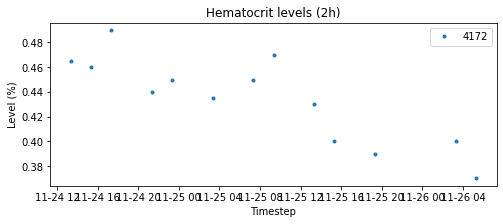

In [250]:
# Show hematocrit levels from random patient
plot_dct(
    dct=data, 
    feature='hematocrit', 
    title='Hematocrit levels (%s)' % INTERVAL_TIME, 
    ylabel='Level (%)', 
    style='.'
)

In [251]:
# Save!
for lab_id in ALL_LAB_IDS:
    lab_id = to_snakecase(lab_id)
    save_dict(OUTPUT_DIR + '/checkpoints', lab_id, {i:data[i][lab_id] for i in data if lab_id in data[i]})

---

## Mechanical Ventilation

The way mechanical ventilation is extracted using MIMIC-Code is slightly different from the AmsterdamUMCdb; from AmsterdamUMCdb we determine use of mechanical ventilation through changes in the settings (which are recorded at specific times and thus have a `charttime`). With MIMIC-Code these settings are already aggregated into intervals of consecutive setting changes with a `starttime` and an `endtime`. In the code below we thus check for the format used and process them accordingly.

In [252]:
vent_df = read_csv(DATA_DIR + 'vent_cohort.csv')
vent_df.head()

# Uses charttime as in AmsterdamUMCdb or intervals as in MIMIC
is_umcdb = 'charttime' in vent_df.columns

In [253]:
for icustay_id, settings in tqdm(vent_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in data:
        continue
        
    # Add urine output to `data` to store aggregated urine measurements
    timesteps = icustay_timesteps[icustay_id]
    data[icustay_id]['mech_vent'] = np.full(len(timesteps) - 1, np.nan)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # AmsterdamUMCdb: charttime in current interval?
        if is_umcdb:
            condition = (settings.charttime > interval_start) & (settings.charttime <= interval_end)    
        else: 
            # MIMIC-III: does ventilation time overlap with current interval?
            condition = (treatments.starttime <= interval_end) & (treatments.endtime > interval_start)
        
        # Were there any settings indicating ventilation?
        data[icustay_id]['mech_vent'][i] = condition.any()
        
del vent_df

100%|████████████████████████████████████████████████████████████████████████████| 16569/16569 [03:48<00:00, 72.55it/s]


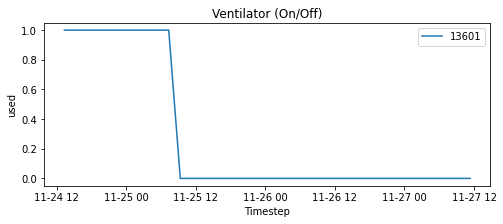

In [262]:
# Show mechanical ventilation over time from random patient
plot_dct(
    dct=data, 
    feature='mech_vent', 
    title='Ventilator (On/Off)', 
    ylabel='used', 
    style='-'
)

In [255]:
# Save!
save_dict(OUTPUT_DIR + '/checkpoints', 'mech_vent', {i:data[i]['mech_vent'] for i in data if 'mech_vent' in data[i]})

---

## Antibiotics

In [263]:
antibiotics_df = read_csv(DATA_DIR + 'antibiotics_cohort.csv')
antibiotics_df.head()

,icustay_id,starttime,endtime,sepsis_antibiotics,profyl_antibiotics,profyl_other
0,0,2022-11-24 18:54:57.069790,2022-11-24 18:55:57.069790,0,1,0
1,0,2022-11-25 03:54:57.069790,2022-11-25 03:55:57.069790,0,1,0
2,0,2022-11-25 12:54:57.069790,2022-11-25 12:55:57.069790,0,1,0
3,1,2022-11-24 16:09:57.069790,2022-11-24 16:10:57.069790,0,1,0
4,1,2022-11-25 04:09:57.069790,2022-11-25 04:10:57.069790,0,1,0


In [264]:
# Consider ICU stays one-by-one
for icustay_id, treatments in tqdm(antibiotics_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in data:
        continue
        
    # To store antibiotics markers into
    timesteps = icustay_timesteps[icustay_id]
    sepsis_antibiotics = np.zeros(len(timesteps) - 1, dtype=np.float32)
    profyl_antibiotics = np.zeros(len(timesteps) - 1, dtype=np.float32)
    other_antibiotics = np.zeros(len(timesteps) - 1, dtype=np.float32)
    
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: treatment time overlaps with current interval.
        # Remark: original R-code erroneously used 'treatment[endtime] <= interval_end' as first term
        condition = (treatments.starttime <= interval_end) & (treatments.endtime > interval_start)
        
        # Compute whether any form of sepsis-related/profylactic anitbiotics was administered
        sepsis_antibiotics[i] = np.nan_to_num(treatments[condition].sepsis_antibiotics.max(), nan=0.0)
        profyl_antibiotics[i] = np.nan_to_num(treatments[condition].profyl_antibiotics.max(), nan=0.0)
        other_antibiotics[i] = np.nan_to_num(treatments[condition].profyl_other.max(), nan=0.0)
        
    data[icustay_id]['sepsis_antibiotics'] = sepsis_antibiotics
    data[icustay_id]['profyl_antibiotics'] = profyl_antibiotics
    data[icustay_id]['other_antibiotics'] = other_antibiotics
    
del antibiotics_df

100%|████████████████████████████████████████████████████████████████████████████| 17387/17387 [15:35<00:00, 18.58it/s]


In [265]:
# Save!
save_dict(OUTPUT_DIR + '/checkpoints', 'sepsis_antibiotics', {i:data[i]['sepsis_antibiotics'] for i in data if 'sepsis_antibiotics' in data[i]})
save_dict(OUTPUT_DIR + '/checkpoints', 'profyl_antibiotics', {i:data[i]['profyl_antibiotics'] for i in data if 'profyl_antibiotics' in data[i]})
save_dict(OUTPUT_DIR + '/checkpoints', 'other_antibiotics', {i:data[i]['other_antibiotics'] for i in data if 'other_antibiotics' in data[i]})

---
## Urine Output

In [271]:
urine_df = read_csv(DATA_DIR + 'urineoutput_cohort.csv')

# Sanity check: drop values outside of expected range
urine_df = urine_df[(urine_df['value'] > 0) & (urine_df['value'] < 2000)]

urine_df.head()

,icustay_id,charttime,value
0,0,2022-11-23 20:46:54.935704,90.0
1,0,2022-11-23 21:16:54.935704,310.0
2,0,2022-11-23 22:16:54.935704,360.0
3,0,2022-11-23 23:16:54.935704,180.0
4,0,2022-11-24 00:16:54.935704,120.0


In [273]:
for icustay_id, measurements in tqdm(urine_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in data:
        continue
        
    # Add urine output to `data` to store aggregated urine measurements
    timesteps = icustay_timesteps[icustay_id]
    data[icustay_id]['total_urine_output'] = np.full(len(timesteps) - 1, np.nan)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: charttime in (interval_start, interval_end)
        condition = (measurements.charttime > interval_start) & (measurements.charttime <= interval_end)    
        
        # Compute total value within timestep
        data[icustay_id]['total_urine_output'][i] = measurements[condition].value.sum()
        
del urine_df

100%|████████████████████████████████████████████████████████████████████████████| 22665/22665 [10:40<00:00, 35.39it/s]


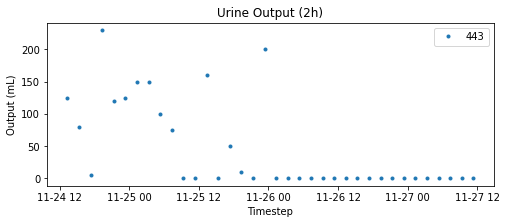

In [274]:
# Grab urine output from random patient
plot_dct(
    dct=data, 
    feature='total_urine_output', 
    title='Urine Output (%s)' % INTERVAL_TIME, 
    ylabel='Output (mL)', 
    style='.'
)

In [275]:
# Save!
save_dict(OUTPUT_DIR + '/checkpoints', 'total_urine_output', {i:data[i]['total_urine_output'] for i in data if 'total_urine_output' in data[i]})

### Urine Output Running Total 

In Roggeveen et al. an additional feature `running_total_urine_output` is included in the feature set;

In [276]:
for icustay_id, icustay_data in data.items():
    if 'total_urine_output' in icustay_data.keys():
        data[icustay_id]['running_total_urine_output'] = np.cumsum(icustay_data['total_urine_output'])

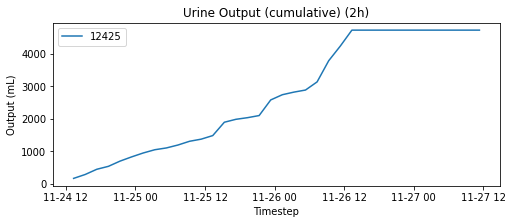

In [277]:
# Grab urine output from random patient
plot_dct(
    dct=data, 
    feature='running_total_urine_output', 
    title='Urine Output (cumulative) (%s)' % INTERVAL_TIME, 
    ylabel='Output (mL)', 
    style='-'
)

In [278]:
# Save!
save_dict(OUTPUT_DIR + '/checkpoints', 'running_total_urine_output', {i:data[i]['running_total_urine_output'] for i in data if 'running_total_urine_output' in data[i]})

---
## FiO2 (Fraction of Inspired Oxygen)

In [279]:
fio2_df = read_csv(DATA_DIR + 'fio2_cohort.csv')
fio2_df.head()

,Unnamed: 0,icustayid,charttime,fio2
0,0,0,2022-11-24 06:53:34.839286,0.35
1,1,0,2022-11-24 08:13:34.839286,0.35
2,2,0,2022-11-24 09:13:34.839286,0.50
3,3,0,2022-11-24 09:14:34.839286,0.90
4,4,0,2022-11-24 10:13:34.839286,0.90


In [281]:
# Process ICU stays one-by-one
for icustay_id, measurements in tqdm(fio2_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    # Add FiO2 ID to `data` to store aggregated measurements
    timesteps = icustay_timesteps[icustay_id]
    data[icustay_id]['fi_o2'] = np.full(len(timesteps) - 1, np.nan)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: charttime in (interval_start, interval_end)
        condition = (measurements.charttime > interval_start) & (measurements.charttime <= interval_end)  
        
        # Compute average value within timestep
        data[icustay_id]['fi_o2'][i] = measurements[condition].fio2.mean()
        
del fio2_df

100%|████████████████████████████████████████████████████████████████████████████| 20399/20399 [09:37<00:00, 35.30it/s]


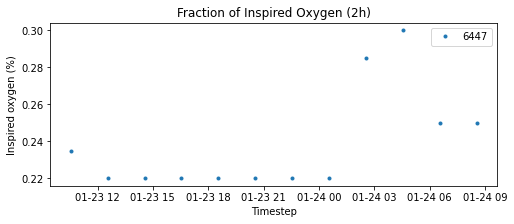

In [290]:
# Grab FiO2 from random patient
plot_dct(
    dct=data, 
    feature='fi_o2', 
    title='Fraction of Inspired Oxygen (%s)' % INTERVAL_TIME, 
    ylabel='Inspired oxygen (%)',
    style='.'
)

In [291]:
# Save!
save_dict(OUTPUT_DIR + '/checkpoints', 'fi_o2', {i:data[i]['fi_o2'] for i in data if 'fi_o2' in data[i]})

---
## Demographics

In [294]:
demo_df = pd.read_csv(DATA_DIR + 'demographics_cohort.csv')
demo_df.head()

,icustay_id,age,is_male,height,weight,vent,sirs,sofa,elective,is_sepsis
0,0,85,0,165.0,65.0,1,2.0,0,1,0
1,1,65,1,175.0,75.0,1,1.0,0,1,0
2,2,65,1,185.0,95.0,1,1.0,0,1,0
3,3,55,1,185.0,95.0,1,2.0,0,0,0
4,4,75,1,175.0,75.0,1,NaN,0,1,0


In [295]:
# Define demographics and disease severity scores of interest (on admission)
DEMOGRAPHICS_COLS = ['age', 'height', 'is_male', 'weight', 'vent', 'sofa', 'sirs', 'elective', 'is_sepsis']
assert all([c in demo_df.columns for c in DEMOGRAPHICS_COLS])

In [296]:
for icustay_id, demographics in tqdm(demo_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    timesteps = icustay_timesteps[icustay_id]
    N = len(timesteps) - 1
    
    # Repeat demographics at each timestep
    for feature in DEMOGRAPHICS_COLS:
        data[icustay_id][feature] = np.ones(N) * demographics[feature].values[0]
        
del demo_df

100%|██████████████████████████████████████████████████████████████████████████| 23106/23106 [00:10<00:00, 2145.84it/s]


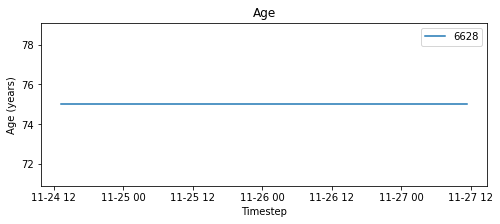

In [297]:
plot_dct(
    dct=data, 
    feature='age', 
    title='Age', 
    ylabel='Age (years)'
)

In [298]:
# Save!
for feature in DEMOGRAPHICS_COLS:
    save_dict(OUTPUT_DIR + '/checkpoints', feature, {i:data[i][feature] for i in data if feature in data[i]})

## Rewards
We define positive terminal reward (R=100) for successful discharge of a patient (i.e. survival beyond hospital stay) and negative reward (R=-100) when the patient does not survive. We issue no intermediate rewards.

In [299]:
# Mapping from admissions to 30-day mortality labels
mortality_dct = {row['icustay_id']: row['hospital_expire_flag'] for _, row in cohort_df.iterrows()}

for icustay_id, patient in tqdm(cohort_df.groupby('icustay_id')):
    
    if icustay_id not in icustay_timesteps or len(icustay_timesteps[icustay_id]) < 2:
        continue
        
    # Determine whether person passed away in hospital
    deceased = mortality_dct[icustay_id]
    
    # Define sparse end-of-episode rewards as +15 on survival; -15 on death
    timesteps = icustay_timesteps[icustay_id]
    rewards = np.zeros(len(timesteps) - 1)
    rewards[-1] = -100 if deceased else 100
    
    data[icustay_id]['reward'] = rewards

100%|█████████████████████████████████████████████████████████████████████████| 23106/23106 [00:00<00:00, 35291.16it/s]


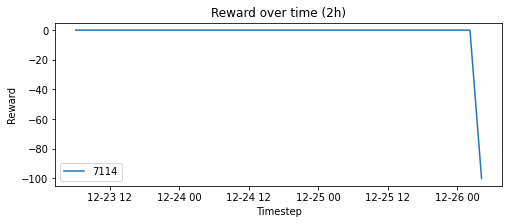

In [300]:
# Grab Reward trajectory from random patient
plot_dct(
    dct=data, 
    feature='reward', 
    title='Reward over time (%s)' % INTERVAL_TIME, 
    ylabel='Reward'
)

In [301]:
# Compute mortality rate
survival = np.mean([1 if np.max(data[icustay_id]['reward']) > 0 else 0 for icustay_id in data if 'reward' in data[icustay_id]])
     
print('mortality rate:', 1 - survival)

mortality rate: 0.09902189907383363


In [302]:
# Save!
save_dict(OUTPUT_DIR + '/checkpoints', 'reward', {i:data[i]['reward'] for i in data if 'reward' in data[i]})

---
# Putting It All Together!

In [ ]:
# TODO: load checkpoints

## Shift IV/VP Forward
By dropping the last VP/IV value (and prepending a `NaN`) we effectively shift the actions, vasopressor doses and IV fluid intakes, one time-step forward (giving us a state representation containing the *previous* vasopressor/IV dose along with the current non-shifted IV/VP and the associated reward);

In [303]:
for icustay_id, icustay_data in data.items():
    
    # Shift actions sequence forward by one
    if 'total_iv_fluid' in data[icustay_id]:
        data[icustay_id]['total_iv_fluid_prev'] = [np.NaN] + list(data[icustay_id]['total_iv_fluid'][:-1])
        
    # Don't forget for running total!
    # Remark: original notebook did not shift running total IV (only total_iv_fluid) 
    # therefore the model was able to relate the current IV level as running_total_iv_fluid - total_iv_fluid_prev!
    if 'running_total_iv_fluid' in data[icustay_id]:
        data[icustay_id]['running_total_iv_fluid_prev'] = [np.NaN] + list(data[icustay_id]['running_total_iv_fluid'][:-1])
        
    if 'max_vaso' in data[icustay_id]:
        data[icustay_id]['max_vaso_prev'] = [np.NaN] + list(data[icustay_id]['max_vaso'][:-1])
        
print('Done!')

Done!


## Convert to DataFrame!

In [304]:
# drop admissions with less than 4 time points
data = {i:data[i] for i in data if 'timestep' in data[i] and len(data[i]['timestep']) > 3}

# Mark measurement by decision time `interval_end` (i.e. drop interval_start)
# Note this is slightly different from what the non-aggregated dataset contains
for icustay_id in data.keys():
    data[icustay_id]['timestep'] = data[icustay_id]['timestep'][1:]

# Convert individual icustay dicts into DataFrames
data_df = {icustay_id: pd.DataFrame.from_dict(icustay_data) for icustay_id, icustay_data in data.items()}

# Add icustay_id as identifier
for icustay_id in data_df.keys():
    data_df[icustay_id]['icustay_id'] = icustay_id
    
# Merge into one large DataFrame
data_df = pd.concat(data_df.values()).reset_index(drop=True)
data_df.head()

,timestep,total_iv_fluid,running_total_iv_fluid,glucose,dias_bp,heart_rate,mean_bp,resp_rate,sp_o2,sv_o2,...,sofa,sirs,elective,is_sepsis,reward,total_iv_fluid_prev,running_total_iv_fluid_prev,icustay_id,max_vaso,max_vaso_prev
0,2022-11-24 15:19:57.069790,666.151306,666.151306,NaN,48.0,77.5,67.0,7.0,75.2500,1.00,...,0.0,2.0,1.0,0.0,0.0,NaN,NaN,0,NaN,NaN
1,2022-11-24 17:19:57.069790,702.773682,1368.925049,NaN,62.5,98.0,83.0,13.0,74.3975,0.59,...,0.0,2.0,1.0,0.0,0.0,666.151306,666.151306,0,NaN,NaN
2,2022-11-24 19:19:57.069790,207.452835,1576.377930,11.4,52.5,105.5,70.0,7.0,50.1600,0.82,...,0.0,2.0,1.0,0.0,0.0,702.773682,1368.925049,0,NaN,NaN
3,2022-11-24 21:19:57.069790,474.067230,2050.445068,10.7,62.0,97.0,79.0,10.5,99.0000,NaN,...,0.0,2.0,1.0,0.0,0.0,207.452835,1576.377930,0,NaN,NaN
4,2022-11-24 23:19:57.069790,204.067230,2254.512207,9.6,56.5,91.0,69.5,8.5,66.1000,0.80,...,0.0,2.0,1.0,0.0,0.0,474.067230,2050.445068,0,NaN,NaN


In [306]:
# For conversion rates see https://github.com/LucaMD/SRL/blob/master/SEPSIS/MIMIC_src/MIMIC_R_DataPreprocessing.ipynb
data_final_df = pd.DataFrame({'icustay_id': data_df['icustay_id'], 
                              'timestep': data_df['timestep'], 
                              ## actions and rewards
                              'max_vaso': data_df['max_vaso'],
                              'total_iv_fluid': data_df['total_iv_fluid'],
                              'reward': data_df['reward'],
                              ## previous treatments
                              'max_vaso_prev': data_df['max_vaso_prev'],
                              'total_iv_fluid_prev': data_df['total_iv_fluid_prev'],
                              'sepsis_antibiotics': data_df['sepsis_antibiotics'],
                              'profyl_antibiotics': data_df['profyl_antibiotics'],
                              'profyl_other': data_df['other_antibiotics'],
                              'ventilator': data_df['mech_vent'], # ventilation over time - not static!
                              ## demographics
                              'sirs_score': data_df['sirs'],
                              'sofa_score': data_df['sofa'],
                              'weight': data_df['weight'],
                              'height': data_df['height'],
                              'age': data_df['age'],
                              'gender': data_df['is_male'],
                              'elective': data_df['elective'],
                              'is_sepsis': data_df['is_sepsis'],
                              ## vitals
                              'heart_rate': data_df['heart_rate'],
                              'temp': data_df['temp_c'],
                              'mean_bp': data_df['mean_bp'],
                              'dias_bp': data_df['dias_bp'],
                              'sys_bp': data_df['sys_bp'],
                              'resp_rate': data_df['resp_rate'],
                              'spo2': data_df['sp_o2'],
                              ## lab results
                              'natrium': data_df['sodium'],
                              'chloride': data_df['chloride'],
                              'kalium': data_df['potassium'],
                              'trombo': data_df['platelet'],
                              'leu': data_df['wbc'],
                              'anion_gap': data_df['anion gap'],
                              'aptt': data_df['ptt'],
                              'art_ph': data_df['ph'],
                              'asat': data_df['asat'],
                              'alat': data_df['alat'],
                              'bicarbonaat': data_df['bicarbonate'],
                              'art_be': data_df['base_excess'],
                              'ion_ca': data_df['ion_calcium'],
                              'lactate': data_df['lactate'],
                              'paco2': data_df['paco2'],
                              'pao2': data_df['pao2'],
                              'fio2': data_df['fi_o2'],
                              'sirs_bands': data_df['bands'], # Not part of feature space
                              'shock_index': data_df['heart_rate'] / data_df['sys_bp'],
                              'hb': data_df['hemoglobin'] * 0.6206, # Conversion rates (see original notebook)
                              'bilirubin': data_df['bilirubin'] * (1 / 0.05847953),
                              'creatinine': data_df['creatinine'] * (1 / 0.01131222),
                              #'inr': data_df['pt'] / 12,
                              'ureum': data_df['bun'] * 0.3571,
                              'albumin': data_df['albumin'] * 10,
                              'magnesium': data_df['magnesium'] * 0.411,
                              'calcium': data_df['calcium'] * 0.25,
                              'pf_ratio': data_df['paco2'] / data_df['fi_o2'],
                              'glucose': data_df['glucose'] * 0.0555,
                              #'cvo2': data_df['cvo2'],
                              'svo2': data_df['sv_o2'],
                              'd-dimer': data_df['d-dimer'],
                              'hematocrit': data_df['hematocrit'],
                              ## other
                              'running_total_urine_output': data_df['running_total_urine_output'],
                              'total_urine_output': data_df['total_urine_output'],
                              'running_total_iv_fluid_prev': data_df['running_total_iv_fluid_prev'],})

In [307]:
# Show data for random patient
icustay_id = random.choice(data_final_df.icustay_id.unique())
data_final_df[data_final_df['icustay_id'] == icustay_id].head()

,icustay_id,timestep,max_vaso,total_iv_fluid,reward,max_vaso_prev,total_iv_fluid_prev,sepsis_antibiotics,profyl_antibiotics,profyl_other,...,magnesium,calcium,pf_ratio,glucose,svo2,d-dimer,hematocrit,running_total_urine_output,total_urine_output,running_total_iv_fluid_prev
555912,15717,2023-01-02 03:07:57.069790,0.0,96.318771,0.0,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,143.333333,0.32745,0.99,NaN,0.29,140.0,140.0,NaN
555913,15717,2023-01-02 05:07:57.069790,0.0,41.738815,0.0,0.0,96.318771,1.0,0.0,0.0,...,0.4521,0.4875,126.666667,0.41625,NaN,NaN,0.30,320.0,180.0,96.318771
555914,15717,2023-01-02 07:07:57.069790,0.0,25.999802,0.0,0.0,41.738815,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,475.0,155.0,138.057587
555915,15717,2023-01-02 09:07:57.069790,0.0,25.999802,0.0,0.0,25.999802,1.0,0.0,0.0,...,NaN,NaN,NaN,0.48840,NaN,NaN,0.33,605.0,130.0,164.057388
555916,15717,2023-01-02 11:07:57.069790,0.0,25.999802,0.0,0.0,25.999802,0.0,0.0,0.0,...,NaN,NaN,NaN,0.45510,0.99,NaN,NaN,685.0,80.0,190.057190


In [308]:
print('Number of admissions:', data_final_df.icustay_id.nunique())

Number of admissions: 23106


### Checkpoint

In [309]:
# save checkpoint before further processing just in case we want to change preprocesing
data_final_df.to_csv(OUTPUT_DIR + '/checkpoints/checkpoint_df.csv', index=False)

In [431]:
# data_final_df = read_csv(OUTPUT_DIR + '/checkpoints/checkpoint_df.csv')
# assert len(data_final_df) > 0

### What do (and don't) we have so far?

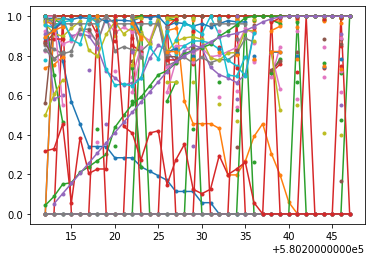

Missing all of:


['ventilator', 'sirs_score', 'sirs_bands', 'd-dimer']

In [456]:
icustay_id = random.choice(data_final_df.icustay_id.unique())

data2 = data_final_df[data_final_df.icustay_id == icustay_id]

missing = []
for col in data2.columns:
    if col not in ['icustay_id', 'action', 'max_vaso', 'total_iv_fluid', 'reward', 'timestep']:
        missing += [col] if np.isnan(data2[col]).all() else []
        x = data2[col] / (data2[col].max() + 1e-10)
        plt.plot(x, '.-')
plt.show()

print('Missing all of:')
missing

## Discretize Action Space

### Calculate Bins

In [443]:
# Compute 5-bin histogram to obtain discrete intervals
def get_quantile_intervals(vals, N=5, max_inf=True, min_inf=True):
    # Drop NaNs and zero doses (they get their own action)
    vals = vals[(vals > 0) & ~np.isnan(vals)].values
        
    # Compute quantiles with special zero bin
    quantiles = [0] + list(np.quantile(vals, np.linspace(0, 1, N)))
    quantiles[0] = -np.inf
    quantiles[1] = 0
    quantiles[-1] = np.inf
    return quantiles
    
max_vp_bins = get_quantile_intervals(data_final_df['max_vaso'])
tot_iv_bins = get_quantile_intervals(data_final_df['total_iv_fluid'])

print('Max VP bins:  ', max_vp_bins)
print('IV fluid bins:', tot_iv_bins)

Max VP bins:   [-inf, 0, 0.006666667, 0.013333334, 0.035, inf]
IV fluid bins: [-inf, 0, 30.0, 97.91221, 172.03918, inf]


<br>

Each bin should have a good number of samples (with exception of the 'zero-bin'):

In [444]:
max_vp_binned = pd.cut(
    data_final_df.max_vaso.fillna(0), 
    right=True, 
    bins=max_vp_bins, 
    labels=[0, 1, 2, 3, 4]
).value_counts()

iv_fluid_shifted_binned = pd.cut(
    data_final_df.total_iv_fluid.fillna(0), 
    right=True, 
    bins=tot_iv_bins, 
    labels=[0, 1, 2, 3, 4]
).value_counts()

pd.DataFrame({'Max VP': max_vp_binned,
              'IV Fluid': iv_fluid_shifted_binned}).transpose()

,0,1,2,3,4
Max VP,734054,31052,18527,23860,24323
IV Fluid,549027,71638,69757,70697,70697


### Convert Continuous Actions to 5x5 Action Space

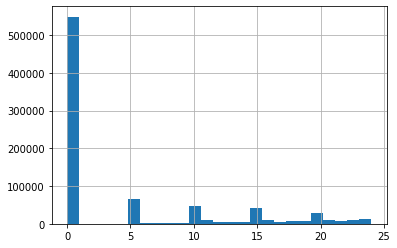

In [445]:
# Replace NaNs by zero (no vasopressor or IV fluid treatment, so dose = zero)
data_final_df['max_vaso'] = data_final_df.max_vaso.fillna(0)
data_final_df['total_iv_fluid'] = data_final_df.total_iv_fluid.fillna(0)
data_final_df['max_vaso_prev'] = data_final_df.max_vaso_prev.fillna(0)
data_final_df['total_iv_fluid_prev'] = data_final_df.total_iv_fluid_prev.fillna(0)

# Use pd.cut to discretize actions
max_vp_discrete = pd.cut(
    data_final_df.max_vaso,
    right=True,
    bins=max_vp_bins, 
    labels=[0, 1, 2, 3, 4]
).astype(float)

total_iv_discrete = pd.cut(
    data_final_df.total_iv_fluid,
    right=True,
    bins=tot_iv_bins, 
    labels=[0, 1, 2, 3, 4]
).astype(float)

# Compute action as 5 * total_iv_fluid + max_vaso
data_final_df['action'] = 5 * total_iv_discrete + max_vp_discrete
data_final_df.action.hist(bins=25);

### Export Action Bins and Action-IV/VP Table

In [457]:
# Save bin edges of max_vaso and total_iv_fluid as .npy files for later reference
with open(OUTPUT_DIR + '/max_vaso_bins.npy', 'w') as file:
    np.savetxt(file, max_vp_bins)
    
with open(OUTPUT_DIR + '/total_iv_fluid_bins.npy', 'w') as file:
    np.savetxt(file, tot_iv_bins)
    
print('Done!')

Done!


In [458]:
# Save mapping from action indices (0 to 24) to bin indices (0 to 4)
action_id_to_bins = dict()
for max_vaso in range(5):
    for total_iv_fluid in range(5):
        action_id_to_bins[5 * total_iv_fluid + max_vaso] = (total_iv_fluid, max_vaso)

with open(OUTPUT_DIR + '/action_to_vaso_fluid_bins.pkl', 'wb') as file:
    pickle.dump(action_id_to_bins, file)
    
print('Done!')

Done!


## Cap Outlying Measurements

During exploratory data analysis it was found that the data was riddled with measurement errors, whereby treatment and vital parameters would take values orders in magnitude higher than would be possible (or safe practice). To ensure feature normalization will not too much be affected by these values, we will cap values to their respective minimum or maximum when outside of their clinically possible range.

However, slight modifications are made to the capping values used in (Roggeveen et al., 2021)
1. Max. `anion_gap`: 12 $\rightarrow$ 40 (as 12 can be considered an acceptable value for even healthy patients depending on the lab and how the test was performed, see [Wikipedia's entry for Anion Gap](https://en.wikipedia.org/wiki/Anion_gap))
2. Min. `shock_index`: 0.5 $\rightarrow$ 0.4 (a value of 0.5 was very often measured (>22.000) and thus the range was slightly relaxed compared to Roggeveen et al.)

**Important**: Note that many values for `age` are capped; these are largely for age 17.999, which in turn is mapped to 18.

In [15]:
# Load capping values (roggeveen et al., 2021)
min_max_values = pd.read_csv('capping_values.csv').set_index('parameter').to_dict('index')

print('Numbers capped:')
for feature, rng in min_max_values.items():
    
    if feature not in data_final_df.columns:
        continue
        
    # Cap values with bounds specific to feature
    capped_values = data_final_df[feature].clip(lower=rng['minval'], upper=rng['maxval'])
        
    # Count non-NaN measurements capped
    num_capped = ((capped_values != data_final_df[feature]) * capped_values.notna()).sum()
    
    # Print features for which many values were capped
    if num_capped > 500:
        print(feature, num_capped)    
    
    data_final_df[feature] = capped_values

Numbers capped:
aptt 1274
bilirubin 2022
calcium 62507
creatinine 68708
dias_bp 1920
fio2 255058
magnesium 41084
mean_bp 1157
paco2 4789
pao2 2071
pf_ratio 57263
resp_rate 7871
shock_index 4938
spo2 9395
sys_bp 1051
temp 8557


## Outlier Removal

From the EDA it was found that many features, if not all, exhibit some form of outliers. As this may affect the feature standardization and scaling, we will cap all measurements above (below) the 99th (1st) percentile.

In [459]:
# columns corresponding to features
metadata = ['icustay_id', 'timestep', 'max_vaso', 'total_iv_fluid', 'reward', 'action']
feature_cols = data_final_df.columns.difference(metadata)

# min and max values in middle 98% of data
min_val = data_final_df[feature_cols].quantile(0.01)
max_val = data_final_df[feature_cols].quantile(0.99)

# replace with 99th/1st quantile upper and lower bounds
for f in feature_cols:
    f_min = min_val[f]
    f_max = max_val[f]
    data_final_df.loc[data_final_df[f] < f_min, f] = f_min
    data_final_df.loc[data_final_df[f] > f_max, f] = f_max

## Exclude Zero-Drug Trajectories

In the dataset there are many patient trajectories in which no treatment is given. Although reasonable to include from a clinical perspective such *zero-drug* trajectories cause major action imbalance, making it difficult for our agent to learn (this is because the policy network will receive many more zero-drug updates than nonzero-drug updates leading its feature network to skew towards overrepresenting this aspect of the action space). As such, we will discard any such trajectories from the dataset (and keep some separate for evaluation if need be)

In [460]:
# estimate zero-drug episodes over training set
zerodrug_episodes = (data_final_df.groupby('icustay_id').action.max() == 0).sum()
perc_zerodrug = 100 * (data_final_df.groupby('icustay_id').action.max() == 0).mean()
print('Admissions without treatment: %d (%.1f%%)' % (zerodrug_episodes, perc_zerodrug))
print('Admissions with treatment:    %d' % ((100 - perc_zerodrug) * zerodrug_episodes / perc_zerodrug))

Admissions without treatment: 7986 (34.6%)
Admissions with treatment:    15120


In [461]:
# list episodes where treatments are prescribed (i.e. some action > 0)
has_treatment = data_final_df.groupby('icustay_id').action.max() > 0
treatment_episodes = has_treatment.index[has_treatment]

# limit dataset to these non-zero-drug episodes
data_final_df = data_final_df[data_final_df.icustay_id.isin(treatment_episodes)].copy()

In [462]:
print(len(data_final_df.icustay_id.unique()))

15120


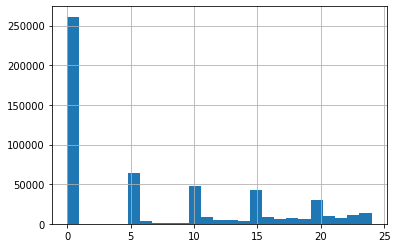

In [463]:
data_final_df.action.hist(bins=25);

## Exclude Admissions with insufficient chart data

There are many admissions where few lab results were charted; we will filter out these admissions when the number of missing values exceeds 20% as our model relies on the existence of (at least some) data to base a decision on;

In [464]:
print('Number of admissions pre-filtering:', data_final_df.icustay_id.nunique())

Number of admissions pre-filtering: 15120


### Missing Variables
We exclude episodes for which very few features have been measured (we want at least 75% of the considered features to be measured during admission)

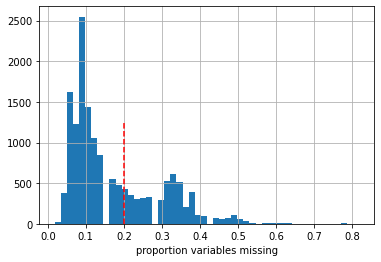

In [465]:
# Mark percentage missing variables for each admission (i.e. no value for Glucose at all)
missing = data_final_df[feature_cols].isna()
missing = missing.groupby(data_final_df.icustay_id).all().mean(axis=1)
missing.hist(bins=50)
plt.plot([0.2, 0.2], [0, 1250], 'r--')
plt.xlabel('proportion variables missing');

In [466]:
# Drop admissions with more than 25% missing (i.e. >75% of features have been measured during admission at least once)
episodes_with_vars = missing.index[missing <= 0.2]
data_final_df = data_final_df[data_final_df.icustay_id.isin(episodes_with_vars)]

In [467]:
print('Number of admissions after-filtering:', data_final_df.icustay_id.nunique())

Number of admissions after-filtering: 10596


## Training, Validation and Test

To train and test the model we need dedicated training, validation (e.g. for hyperparameter tuning) and test sets. We perform the splitting below;

In [468]:
# For reproduction sake!
random.seed(10)

In [469]:
# Specify fraction of ICU-stays for training, validation and testing
frac_train = 0.7
frac_valid = 0.1

# Randomly assign icustay_ids to train, val and test
icustay_ids = list(data_final_df['icustay_id'].unique())
random.shuffle(icustay_ids)

num_train = int(len(icustay_ids) * frac_train)
num_valid = int(len(icustay_ids) * frac_valid)

train_icustays = icustay_ids[:num_train]
valid_icustays = icustay_ids[num_train:num_train + num_valid]
test_icustays = icustay_ids[num_train + num_valid:]

# Store train/valid/test icustay_ids
np.savetxt(OUTPUT_DIR + '/icustay_ids_train.npy', train_icustays)
np.savetxt(OUTPUT_DIR + '/icustay_ids_valid.npy', valid_icustays)
np.savetxt(OUTPUT_DIR + '/icustay_ids_test.npy', test_icustays)

print('Dataset instances:')
print('Train  %s' % len(train_icustays))
print('Valid  %s' % len(valid_icustays))
print('Test   %s' % len(test_icustays))

Dataset instances:
Train  7417
Valid  1059
Test   2120


In [470]:
data_train_df = data_final_df[data_final_df['icustay_id'].isin(train_icustays)].reset_index(drop=True)
data_valid_df = data_final_df[data_final_df['icustay_id'].isin(valid_icustays)].reset_index(drop=True)
data_test_df = data_final_df[data_final_df['icustay_id'].isin(test_icustays)].reset_index(drop=True)
print('Done!')

Done!


## Imputation

### Forward-Filling Imputation

Lab results are made very infrequently, therefore most timesteps will miss these values. We follow (Roggeveen et al., 2021) and use forward-filling (or Last-Value Carried Forward Imputations) to impute these missing values; however, unlike Roggeveen et al., we limit the maximum extend to the forward filling to ensure backfilled values remain reasonably reliable (we cannot assume a value to be reliable 2 days after it was last measured)

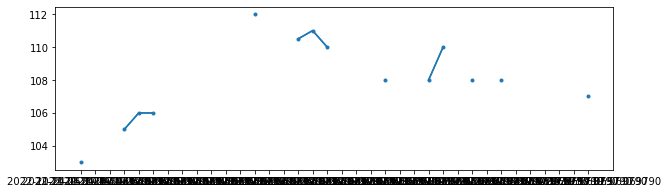

In [472]:
icustay_id = plot_df(data_train_df, feature='chloride')

In [473]:
# Columns corresponding to lab measurements
FFILL_COLS = ['heart_rate', 'temp', 'mean_bp', 'dias_bp', 'sys_bp', 'resp_rate', 'spo2', 'natrium', 'chloride', 'kalium', 'trombo', 
              'leu', 'anion_gap', 'aptt', 'art_ph', 'asat', 'alat', 'bicarbonaat', 'art_be', 'ion_ca', 'lactate', 'paco2', 'pao2', 
              'fio2', 'sirs_bands', 'shock_index', 'hb', 'bilirubin', 'creatinine', 'ureum', 'albumin', 'magnesium', 'calcium', 
              'pf_ratio', 'glucose', 'd-dimer', 'hematocrit', 'running_total_urine_output', 'total_urine_output']

assert all([c in data_train_df.columns for c in FFILL_COLS])

In [474]:
for dataset in [data_train_df, data_valid_df, data_test_df]:
    for col in FFILL_COLS:
        dataset.loc[:, col] = dataset.groupby('icustay_id', sort=False)[col].ffill(limit=12) # max 1 day

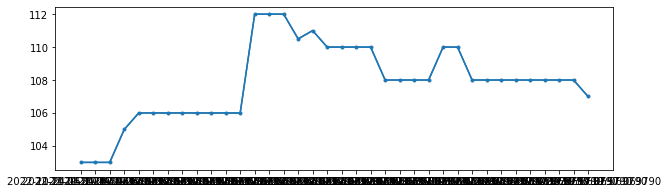

In [475]:
plot_df(data_train_df, feature='chloride', icustay_id=icustay_id);

Note the long leading trail of no measured values. This is because the window may go beyond the monitoring period of the admission. We will fix this problem and truncate these trajectories later on.

### KNN Imputation
Some points that are missing lie 'outside' of the recorded set of measurements (i.e. there is no point to the left or right) or multiple-adjacent values are missing -- to resolve these we need extrapolation. To this end, we use a kNN-based imputation with k=3 nearest neighbors within episode.

In [477]:
# Example of admissions with all NaNs in one column
for icustay_id, example in data_train_df.groupby('icustay_id'):
    if np.any(example.isna().all(axis=0)):
        break
        
all_missing = example.isna().all(axis=0)
print('Admission with all NaN columns:', icustay_id)
print('Missing:', all_missing.index[all_missing].to_list())

Admission with all NaN columns: 0
Missing: ['chloride', 'asat', 'alat', 'lactate', 'sirs_bands', 'bilirubin', 'ureum', 'd-dimer']


In [478]:
# We define the field to be KNN imputed as the combined set of lab results and vitals
IMPUTING_FIELDS = FFILL_COLS + ['running_total_iv_fluid_prev']

In [479]:
def impute_with_knn(dataset, imputing_fields):
    X_result = []
    for icustay_id, group_data in tqdm(dataset.groupby('icustay_id', sort=False), position=0, leave=True):
        # Impute features using KNN
        X_incomplete = group_data[imputing_fields]       
        X_imputed = KNN(k=3, verbose=False).fit_transform(X_incomplete)
        
        # If the column is all NaNs, the KNN imputer sets these values to zeroes
        # As median imputation is preferred in this case, we put back the NaNs for now
        all_missing = X_incomplete.isna().all(axis=0).values
        X_imputed[:, all_missing] = np.NaN
        
        X_result.append(X_imputed)
                
    # Concatenate into large ndarray
    X_result = np.concatenate(X_result, axis=0)
    
    # Fill in DataFrame feature-by-feature
    for i, f in enumerate(imputing_fields):
        dataset.loc[:, f] = X_result[:, i]
    return dataset

data_train_df = impute_with_knn(data_train_df, IMPUTING_FIELDS)
data_valid_df = impute_with_knn(data_valid_df, IMPUTING_FIELDS)
data_test_df = impute_with_knn(data_test_df, IMPUTING_FIELDS)

data_valid_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 2120/2120 [00:17<00:00, 119.60it/s]


,icustay_id,timestep,max_vaso,total_iv_fluid,reward,max_vaso_prev,total_iv_fluid_prev,sepsis_antibiotics,profyl_antibiotics,profyl_other,...,calcium,pf_ratio,glucose,svo2,d-dimer,hematocrit,running_total_urine_output,total_urine_output,running_total_iv_fluid_prev,action
0,12,2022-11-24 15:19:57.069790,0.0,188.06723,0.0,0.0,0.000000,0.0,1.0,0.0,...,0.385,NaN,0.46065,NaN,NaN,0.27,125.0,125.0,277.860052,20.0
1,12,2022-11-24 17:19:57.069790,0.0,188.04388,0.0,0.0,188.067230,0.0,0.0,0.0,...,0.385,NaN,0.46065,NaN,NaN,0.27,269.0,144.0,188.067230,20.0
2,12,2022-11-24 19:19:57.069790,0.0,188.06723,0.0,0.0,188.043884,0.0,0.0,0.0,...,0.385,NaN,0.46065,NaN,NaN,0.27,349.0,80.0,376.111115,20.0
3,12,2022-11-24 21:19:57.069790,0.0,688.06720,0.0,0.0,188.067230,0.0,1.0,0.0,...,0.385,NaN,0.36075,NaN,NaN,0.26,469.0,120.0,564.178345,20.0
4,12,2022-11-24 23:19:57.069790,0.0,188.04393,0.0,0.0,652.032898,0.0,0.0,0.0,...,0.385,NaN,0.36075,NaN,NaN,0.26,604.0,135.0,1252.245605,20.0


### Median Imputation

If for a given admission no data was charted at all for a certain feature within an admission, we fall back on imputation using the median of respective feature in the training set (we use the median, not the mean, as the data has some positive or negative skew, see histograms below);

In [480]:
train_median = data_train_df.median(numeric_only=True)

data_train_df = data_train_df.fillna(train_median)
data_valid_df = data_valid_df.fillna(train_median)
data_test_df = data_test_df.fillna(train_median)

data_valid_df.head()

,icustay_id,timestep,max_vaso,total_iv_fluid,reward,max_vaso_prev,total_iv_fluid_prev,sepsis_antibiotics,profyl_antibiotics,profyl_other,...,calcium,pf_ratio,glucose,svo2,d-dimer,hematocrit,running_total_urine_output,total_urine_output,running_total_iv_fluid_prev,action
0,12,2022-11-24 15:19:57.069790,0.0,188.06723,0.0,0.0,0.000000,0.0,1.0,0.0,...,0.385,120.0,0.46065,0.97,3.85,0.27,125.0,125.0,277.860052,20.0
1,12,2022-11-24 17:19:57.069790,0.0,188.04388,0.0,0.0,188.067230,0.0,0.0,0.0,...,0.385,120.0,0.46065,0.97,3.85,0.27,269.0,144.0,188.067230,20.0
2,12,2022-11-24 19:19:57.069790,0.0,188.06723,0.0,0.0,188.043884,0.0,0.0,0.0,...,0.385,120.0,0.46065,0.97,3.85,0.27,349.0,80.0,376.111115,20.0
3,12,2022-11-24 21:19:57.069790,0.0,688.06720,0.0,0.0,188.067230,0.0,1.0,0.0,...,0.385,120.0,0.36075,0.97,3.85,0.26,469.0,120.0,564.178345,20.0
4,12,2022-11-24 23:19:57.069790,0.0,188.04393,0.0,0.0,652.032898,0.0,0.0,0.0,...,0.385,120.0,0.36075,0.97,3.85,0.26,604.0,135.0,1252.245605,20.0


In [482]:
# sanity check
assert np.all(data_train_df.notna())

## Feature Standardization
To satisfy the input assumptions of neural networks, we standardize the input features to be centered and approximately (unit) normal. To this end, we perform various transformations (e.g. log/exp transformations) to standardize the data. These transformations are guided by the value distributions seen in the [exploratory data analysis](https://github.com/thomas097/Haemodynamic-Optimization-Reinforcement-Learning/tree/main/exploratory_analysis) (EDA); for completeness, we plot the distribution of our features here again.

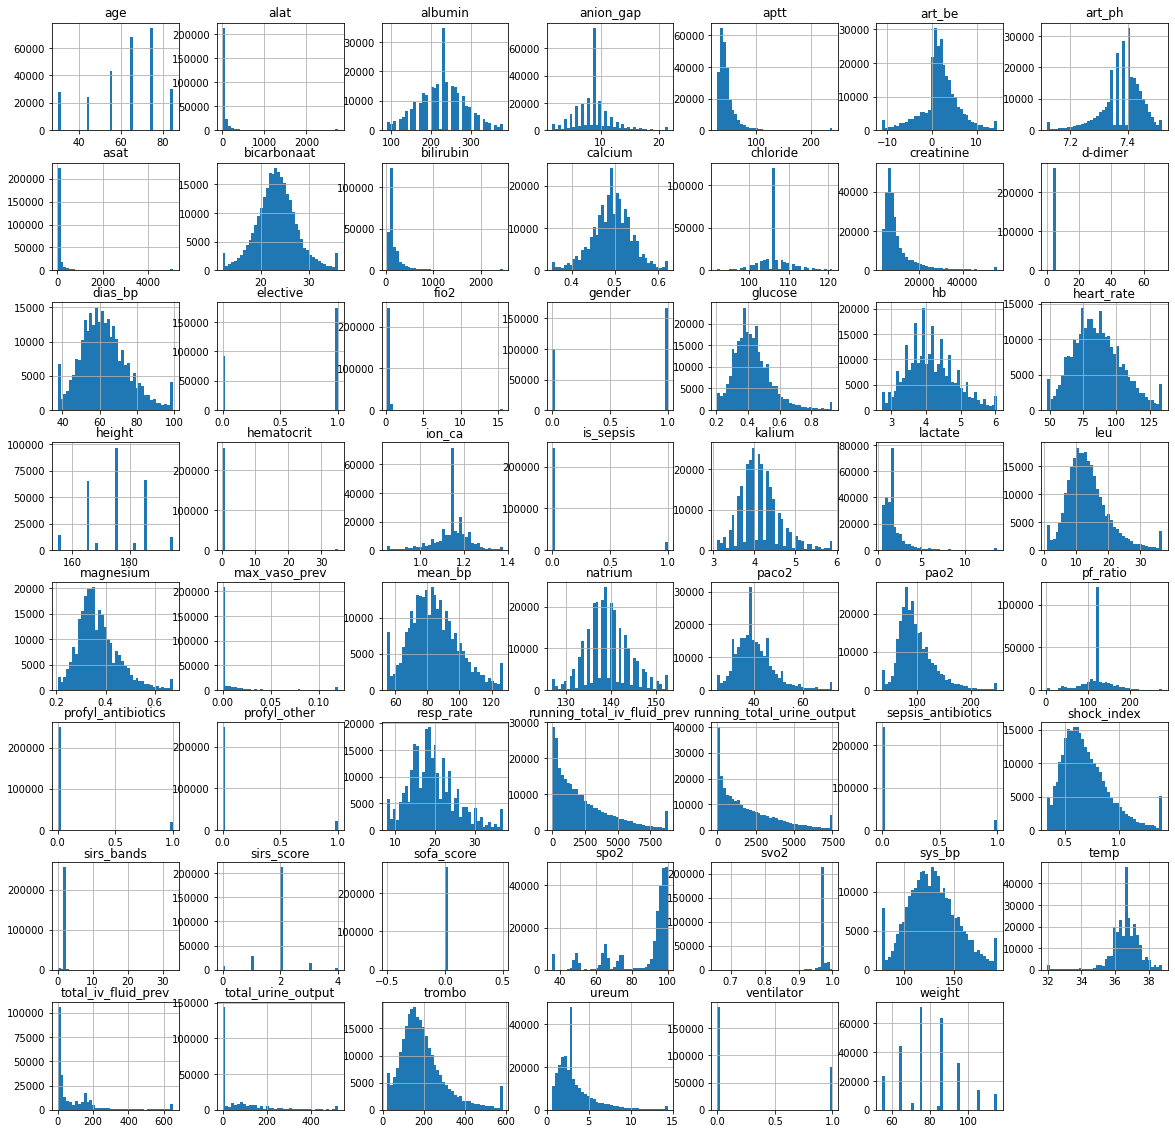

In [483]:
data_train_df[feature_cols].hist(figsize=(20, 20), bins=40);

In [484]:
BINARY_FIELDS = ['ventilator', 'gender', 'elective', 'is_sepsis', 'sepsis_antibiotics', 'profyl_antibiotics', 'profyl_others']

# features with positive/right skew
LOG_FIELDS = ['alat', 'asat', 'aptt', 'bilirubin', 'creatinine', 'lactate', 'max_vaso_prev', 'total_iv_fluid_prev', 
              'total_urine_output', 'running_total_iv_fluid_prev', 'running_total_urine_output', 'ureum', 'sirs_bands'] # 'inr'

# features with negative/left skew
EXP_FIELDS = ['art_ph', 'spo2', 'svo2']

# we scale inputs to exp to prevent exponential blow-up
# the parameters below were found empirically
EXP_SCALE = {
    'art_ph': 0.75,
    'spo2': 6,
    'svo2': 0.25,
}

EXCLUDE = ['icustay_id', 'timestep', 'reward', 'action', 'max_vaso', 'total_iv_fluid']

### Z-scoring and Log-Transformation

In [485]:
def log_transform(x):
    return np.log(x + 1)

def exp_transform(x, scale):
    return np.exp(x / scale)

def zscore(x, mean, stdev):
    stdev = stdev if stdev > 0 else 1.0 # prevent divide-by-zero
    return (x - mean) / stdev

In [486]:
# Estimate feature means & stdevs from training set
# taking into account subsequent transformation with log/exp
params = dict()
for f in feature_cols:
    if f in EXP_FIELDS:
        # exp transform
        x = exp_transform(data_train_df[f], scale=EXP_SCALE[f])
    elif f in LOG_FIELDS:
        # log transform
        x = log_transform(data_train_df[f])
    else:
        x = data_train_df[f]
        
    params[f] = (x.mean(), x.std())

# Perform stndardization with values from data_train_df
for df in [data_train_df, data_valid_df, data_test_df]:
    for f in tqdm(feature_cols):
        if f in BINARY_FIELDS:
            # Centering
            df.loc[:, f] = df[f] - 0.5  
        elif f in EXP_FIELDS:
            # Exp-transform + z-scoring
            factor = EXP_SCALE[f]
            df.loc[:, f] = zscore(exp_transform(df[f], scale=factor), *params[f])
        elif f in LOG_FIELDS:
            # Log-transform + z-scoring
            df.loc[:, f] = zscore(log_transform(df[f]), *params[f])
        else:
            # Z-scoring
            df.loc[:, f] = zscore(df[f], *params[f])
                
print('Done!')

100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 470.05it/s]

Done!


In [487]:
# just in case: cap outliers again with parameters from training set
capping_params = dict()
for f in feature_cols:
    f_min = data_train_df[f].quantile(0.01)
    f_max = data_train_df[f].quantile(0.99)
    capping_params[f] = (f_min, f_max)
    
for df in [data_train_df, data_valid_df, data_test_df]:
    for f in feature_cols:
        if f not in BINARY_FIELDS:
            f_min, f_max = capping_params[f]
            df.loc[df[f] < f_min, f] = f_min
            df.loc[df[f] > f_max, f] = f_max

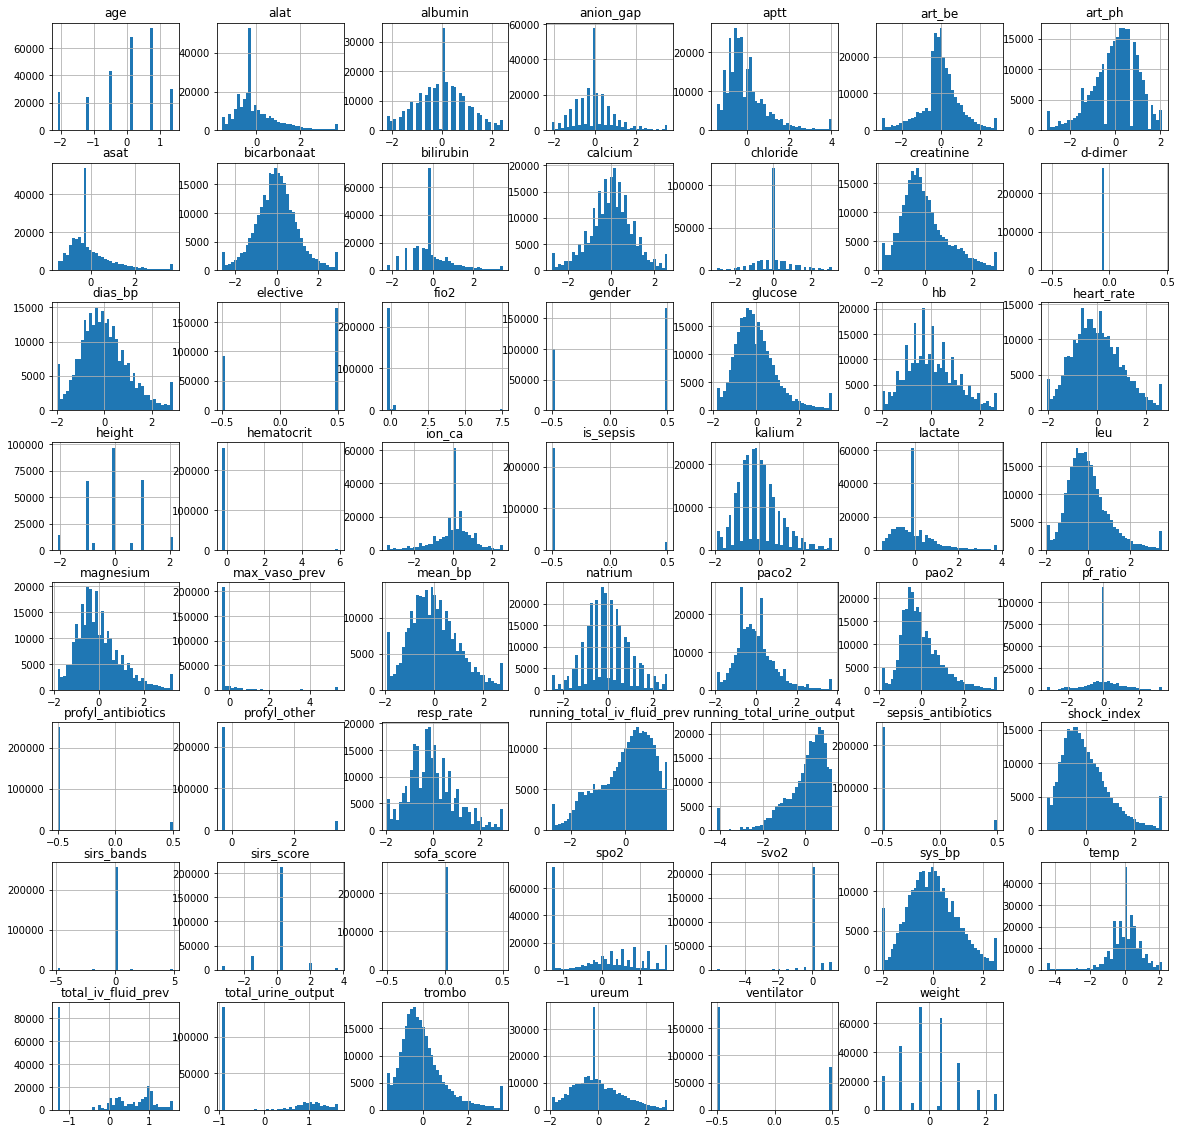

In [488]:
data_train_df[feature_cols].hist(figsize=(20, 20), bins=40);

In [491]:
# sanity check divide-by-zero -> NaN
assert np.all(data_train_df.notna())

## Rename Columns to `X*`

In the source code we may wish to refer to the list of features without defining the names of the features each time, i.e. `['heart_rate', 'albumin', 'leu', 'resp_rate', 'fio2', ...]` etc. Much easier is to simply refer to the columns as `x0` to `x49` which we can create procedurally. Below we will define a mapping from state-space features to their `x*`equivalents;

In [492]:
STATE_SPACE_COLUMNS = ['max_vaso_prev', 'total_iv_fluid_prev', 'sepsis_antibiotics', 'profyl_antibiotics', 'profyl_other', 
                       'ventilator', 'sirs_score', 'sofa_score', 'weight', 'height', 'age', 'gender', 'elective', 'is_sepsis', 
                       'heart_rate', 'temp', 'mean_bp', 'dias_bp', 'sys_bp', 'resp_rate', 'spo2', 'natrium', 'chloride', 
                       'kalium', 'trombo', 'leu', 'anion_gap', 'aptt', 'art_ph', 'asat', 'alat', 'bicarbonaat', 'art_be',
                       'ion_ca', 'lactate', 'paco2', 'pao2', 'fio2', 'sirs_bands', 'shock_index', 'hb', 'bilirubin', # 'inr'
                       'creatinine', 'ureum', 'albumin', 'magnesium', 'calcium', 'pf_ratio', 'glucose', 'd-dimer', 'svo2',
                       'hematocrit', 'running_total_urine_output', 'total_urine_output', 'running_total_iv_fluid_prev']

# Check if all features in `data_train_df`
for col in STATE_SPACE_COLUMNS:
    if col not in data_train_df:
        raise Exception('%s not in data_train_df' % col)

# Write out file for later reference
with open(OUTPUT_DIR + '/state_space_features.txt', 'w') as f:
    for col in STATE_SPACE_COLUMNS:
        f.write("%s\n" % col)

In [493]:
# Create x* name for each column
new_state_space_columns = {feat:'x%s' % i for i, feat in enumerate(STATE_SPACE_COLUMNS)}

# Replace 'icustay_id' by 'episode'
new_state_space_columns['icustay_id'] = 'episode'

# Rename columns
data_train_df = data_train_df.rename(columns=new_state_space_columns)
data_valid_df = data_valid_df.rename(columns=new_state_space_columns)
data_test_df = data_test_df.rename(columns=new_state_space_columns)

## Exclude Impossible Actions

Just in case there are any, drop instances where no IV fluids are given but vasopressor is administered (actions 0-4). This should not be possible as vasopressors are, in fact, fluids themselves!

In [494]:
DISALLOWED_ACTIONS = [1, 2, 3, 4]

In [495]:
for dataset in [data_train_df, data_valid_df, data_test_df]:
    not_allowed = dataset.action.isin(DISALLOWED_ACTIONS)
    print('Dropping', np.sum(not_allowed))
    dataset.loc[not_allowed, 'action'] = 0

Dropping 157
Dropping 34
Dropping 70


In [496]:
# How many 1's are still in the training dataset?
np.sum(data_train_df.action == 1)

0

## Drop Excess States

In the dataset we try to include as much of the patient trajectory within the time frame of each admission. However, variables are often (but not always) recorded for much shorter time periods within the admission, causing empty states to occur where no vitals/lab results were registered (i.e. the patient was likely already transferred to another ward or at home). As these states offer little use for training and evaluation we drop these states from our dataset.

In [543]:
def drop_excess_states(df, min_change=1e-2, min_vars_changing=12):
    episodes = []
    for episode, episode_df in tqdm(df.groupby('episode')):        
        # are there changes from state to state (at least N variables change significantly)?
        diffs = episode_df.filter(regex='x\d+').diff(periods=2).values
        diffs[0] = diffs[2] # replace NaNs with 2nd time step
        diffs[1] = diffs[2] # replace NaNs with 2nd time step
        has_data = np.sum(np.absolute(diffs) > min_change, axis=1) > (min_vars_changing - 1)
        
        # drop only trailing or leading 'empty' states (not those in between)
        has_data_trailing = has_data[::-1].cumsum()[::-1] > 0
        has_data_leading = has_data.cumsum() > 0
        has_data = np.logical_and(has_data_trailing, has_data_leading)
        
        # what was the terminal reward of episode?
        reward = episode_df.reward.values[-1]
        
        # drop artificial trailing states (when no treatment, nor vitals)
        episode_df = episode_df[has_data].copy()
        
        # put back reward at *new* terminal state
        try:
            if len(episode_df) > 1:
                episode_df.iloc[-1, episode_df.columns.get_loc('reward')] = reward
                episodes.append(episode_df)
        except:
            pass
        
    return pd.concat(episodes, axis=0)
    

data_train_df = drop_excess_states(data_train_df)
data_valid_df = drop_excess_states(data_valid_df)
data_test_df = drop_excess_states(data_test_df)

100%|█████████████████████████████████████████████████████████████████████████████| 2120/2120 [00:02<00:00, 866.53it/s]


<AxesSubplot:>

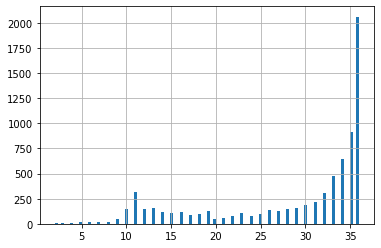

In [544]:
data_train_df.groupby('episode').size().hist(bins=100)

In [545]:
# We drop admissions beyond 100 time steps (~8 days)
def truncate(df, max_duration=150):
    los = df.groupby('episode').size()
    short_episodes = los.index[los < max_duration]
    return df[df.episode.isin(short_episodes)]

data_train_df = truncate(data_train_df)
data_valid_df = truncate(data_valid_df)
data_test_df = truncate(data_test_df)

## Export Datasets

In [546]:
# Sort by timestep and episode
data_train_df = data_train_df.sort_values(['episode', 'timestep'])
data_valid_df = data_valid_df.sort_values(['episode', 'timestep'])
data_test_df = data_test_df.sort_values(['episode', 'timestep'])

In [547]:
# Don't forget to save!!
data_train_df.to_csv(OUTPUT_DIR + '/train.csv', index=False)
data_valid_df.to_csv(OUTPUT_DIR + '/valid.csv', index=False)
data_test_df.to_csv(OUTPUT_DIR + '/test.csv', index=False)
print('Done!')

Done!


### Memory Usage

In [548]:
# Size of whole dataset (train + valid + test) including all admissions
num_admissions = data_final_df.icustay_id.nunique()
print('Number of admissions:', num_admissions)

full_df_gigs = data_final_df.memory_usage(deep=True).sum() / (1 << 30)
print('Expected memory usage of dataset: %sGB' % round(full_df_gigs, 2)) 

Number of admissions: 10596
Expected memory usage of dataset: 0.2GB


---

## Sanity Checks

<AxesSubplot:>

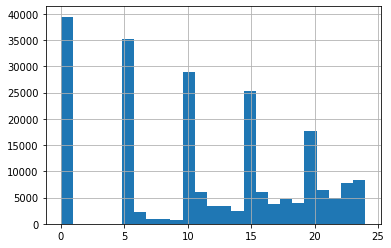

In [549]:
data_train_df.action.hist(bins=25)

missing: anion_gap
missing: chloride
missing: d-dimer
missing: elective
missing: fio2
missing: ion_ca
missing: is_sepsis
missing: pf_ratio
missing: profyl_other
missing: sepsis_antibiotics


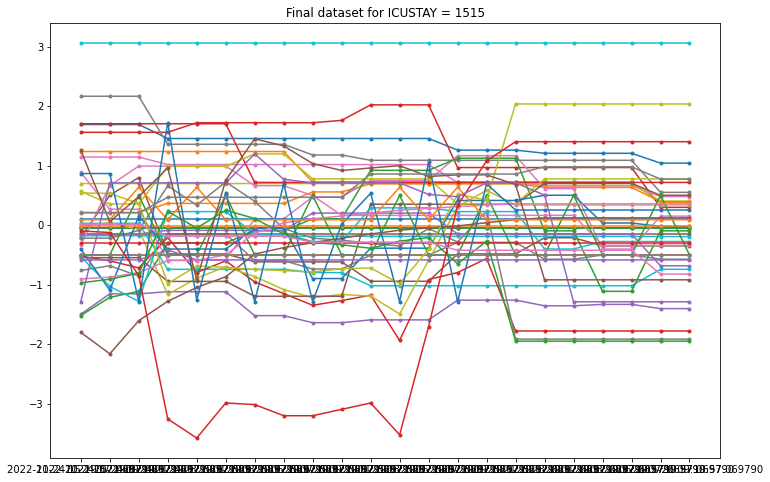

In [551]:
# Limit plot to one ICU stay
icustay_id = random.choice(list(data_train_df.episode.unique()))
icustay_df = data_train_df[data_train_df.episode == icustay_id]

# change this to visualize other feature
FEATURES = [c for c in feature_cols if c not in 'gender age sirs_score sofa_score ventilator weight height']
# ['alat', 'albumin', 'aptt', 'art_be', 'svo2', 'sirs_bands', 'd-dimer', 'lactate', 'pao2']

plt.figure(figsize=(12, 8))
for f in FEATURES:
    x_name = 'x%d' % STATE_SPACE_COLUMNS.index(f)
        
    plt.plot(icustay_df['timestep'], icustay_df[x_name], label=f, marker='.')

    # which measurements were not recorded?
    if icustay_df[x_name].diff().abs().mean() == 0:
        print('missing:', f)
        
plt.title('Final dataset for ICUSTAY = %s' % icustay_id)
#plt.legend(ncol=3, prop={'size': 8})
plt.show()

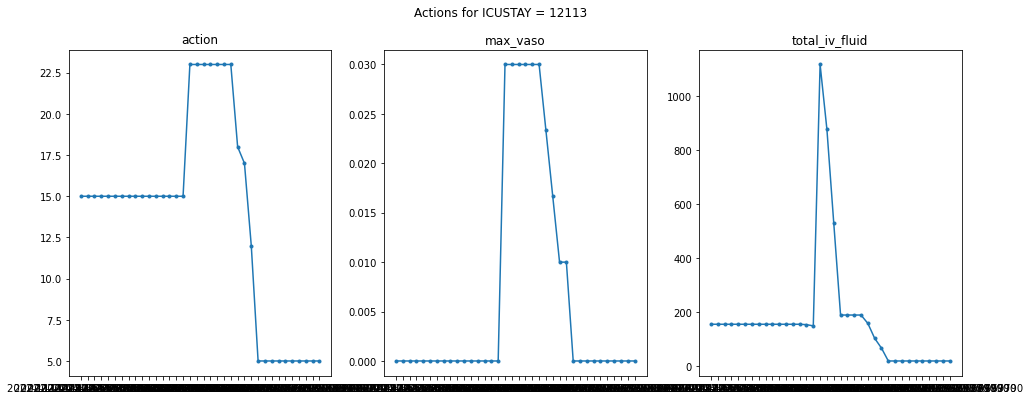

In [572]:
# Limit plot to one ICU stay
icustay_id = random.choice(list(data_train_df.episode.unique()))
icustay_df = data_train_df[data_train_df.episode == icustay_id]

# Plot interesting columns
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.title('action')
plt.plot(icustay_df.timestep, icustay_df.action, marker='.')

plt.subplot(1, 3, 2)
plt.title('max_vaso')
plt.plot(icustay_df.timestep, icustay_df.max_vaso, marker='.')

plt.subplot(1, 3, 3)
plt.title('total_iv_fluid')
plt.plot(icustay_df.timestep, icustay_df.total_iv_fluid, marker='.')
        
plt.suptitle('Actions for ICUSTAY = %s' % icustay_id)
plt.show()

### General Statistics

In [558]:
print('Admissions:')
print('Train:', len(data_train_df['episode'].unique()))
print('Valid:', len(data_valid_df['episode'].unique()))
print('Test: ', len(data_test_df['episode'].unique()))

Admissions:
Train: 7406
Valid: 1059
Test:  2119


In [559]:
actionable_episodes = (data_train_df.groupby('episode').action.max() > 0).sum()
print('Training admissions with non-zero actions:', actionable_episodes)

Training admissions with non-zero actions: 7372


In [560]:
data_train_df['has_IV'] = data_train_df.action >= 5
data_train_df['has_VP'] = data_train_df.action % 5 != 0
episodes_with_iv = (data_train_df.groupby('episode').has_IV.max()).sum()
episodes_with_vp = (data_train_df.groupby('episode').has_VP.max()).sum()
total_episodes = len(data_train_df.episode.unique())

print('% Training episodes with IV fluids:   ', 100 * episodes_with_iv / total_episodes)
print('% Training episodes with vasopressors:', 100 * episodes_with_vp / total_episodes)

% Training episodes with IV fluids:    99.54091277342695
% Training episodes with vasopressors: 53.37564137186065
